In [49]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import pandas as pd

In [28]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [72]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [73]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [74]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [75]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [76]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [77]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [76]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#session.query(Measurement.date).group_by(Measurement.date).distinct().all()
#First attenmpt- code above did not work but keeping incase needed later. 

In [78]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [79]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [80]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [83]:
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [84]:
dates = session.query(Measurement.date).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()


In [91]:
# Dates from last 12 months conitnued 
dates = dt.datetime.strptime("2017-08-23", "%Y-%m-%d")
numdays = 365
dates_year = [dates - dt.timedelta(days=x) for x in range(0, numdays)]


In [92]:
str_dates = []
for date in dates_year:
    new_date = date.strftime("%Y-%m-%d")
    str_dates.append(new_date)

In [131]:
# Presipitation Data
prcp_results = session.query(func.avg(Measurement.prcp), Measurement.date)\
    .filter(Measurement.date.in_('str_dates'))\
    .group_by(Measurement.date)

In [132]:
prcp_data = []
for res in prcp_results:
    prcp_data.append(res[0])

In [123]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
    #prcp_df = pd.DataFrame([str_dates[::-1], prcp_data[::-1]]).T
    #prcp_df.rename(columns={0: "Date", 1: "Precipitation"}, inplace=True)
    #prcp_df.set_index("Date", inplace=True)
    #prcp_df.head(15)

#this has been unsuccessful in showing precipitation results but keeping for reference for summary statistics work 


In [122]:
session = Session(engine)
conn = engine.connect()
prcp_data_df = pd.read_sql("SELECT date, prcp AS 'precipitation' \
FROM Measurement WHERE date >= '2017-08-23'", conn)
prcp_data_df.head()

,date,precipitation
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45


<function matplotlib.pyplot.show(*args, **kw)>

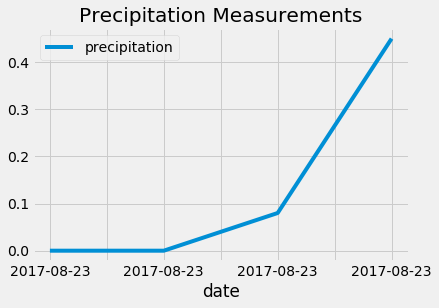

In [128]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_data_df.plot(x='date', y='precipitation')
plt.title("Precipitation Measurements")
plt.show

In [136]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_data_df.describe()

,precipitation
count,4.0000
mean,0.1325
std,0.2150
min,0.0000
25%,0.0000
50%,0.0400
75%,0.1725
max,0.4500


In [137]:
# Design a query to show how many stations are available in this dataset?
engine.execute('SELECT * FROM station LIMIT 5').fetchall()


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [138]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [144]:
#station_query = engine.execute('SELECT DISTINCT station FROM measurement \
#WHERE date >= '2017-08-23'")
# ERROR: Invalid syntax on date


SyntaxError: invalid syntax (<ipython-input-144-66e72b14b025>, line 2)

In [148]:
station_query = session.query(func.count(Station.station))
stations_available = station_query[0]
stations_available

(9)

In [ ]:
# There are 9 Number of Stations Available 

In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
